## GRASPHPO Evaluation/Data Visualization

Python Modules Required:

To install Python modules, run `pip install _module_name_here_` in either a Windows or Linux terminal.
If you don't already have `pip` installed, see [here](https://pip.pypa.io/en/stable/installation/) for instructions on how to do so.
- `sklearn`
- `xgboost`
- `numpy`
- `ray`
- `hyperopt`
- `pandas`
- `ConfigSpace`
- `matplotlib`

Once all the required modules are installed, you can go to Cell/Run All to start testing.

To add a new HPO algorithm to the setup for testing, you'll need to write a new Class that inherits HPOStrategy, and then overwrite the `hyperparameter_optimization()` method with whatever you want the HPO algorithm to be, and have it return `best_parameters_found, f1_score_of_best_parameters`. To then have it run against the other HPO algorithms, first add a new elif statement to the `create_hpo_strategy()` method below with the string you want to use to identify the class and return the class function. Then add the HPO id string to the list in the main method with the other HPO algorithm id strings, and it should now call your new HPO algorithm method.

To add a new dataset to the setup for testing, have whatever method your use to load/create the new dataset return an instance of the `Dataset()` class shown, with a data matrix (number of samples (rows) x number of features (cols)) implemented as a Pandas DataFrame and a target array (length equal to the number of samples) implemented as a Pandas Series. Then add a new elif statement to the `load_dataset()` method in the DatasetFactory class with the string you want to use to identify the class and return the class function. Then add the dataset id string to the list in the main method with the other dataset id strings, and it should now use your new dataset in the testing routine.

#### Factory Method Implementation

In [53]:
from abc import abstractmethod, ABC

class HPOStrategy(ABC):
    @abstractmethod
    def hyperparameter_optimization(self, x_train, x_test, y_train, y_test, search_space):
        pass#method should return
    
class HPOFactory:
    @staticmethod
    def create_hpo_strategy(strategy_name):
        if strategy_name == 'GraspHpo':
            return GraspHpo()
        elif strategy_name == 'Hyperband':
            return Hyperband()
        elif strategy_name == "HyperOpt":
            return HyperOpt()
        elif strategy_name == "BOHB":
            return BOHB()
        elif strategy_name == 'None':
            return Default()
        #new HPO algorithms go here
        else:
            raise ValueError("Invalid HPO strategy name")

#### Construction Phase (GRASPHPO)

In [54]:
import uuid
import random
import time
import math
from sklearn.preprocessing import StandardScaler
from queue import PriorityQueue


class Construction:

    
    def __init__(self, evaluate, MAX, INT_RESULT_SIZE) -> None:
        self.evaluate = evaluate
        self.max_iter = MAX
        self.int_res_size = INT_RESULT_SIZE

    def get_random_hyperparameter_value(self, hyperparameter, hyperparameter_range):
        if hyperparameter in ['max_depth','n_estimators']:
            return random.randint(hyperparameter_range[0], hyperparameter_range[1])
        elif hyperparameter in ['learning_rate']:
            return random.lognormvariate(hyperparameter_range[0], hyperparameter_range[1])
        else:
            return random.uniform(hyperparameter_range[0], hyperparameter_range[1])
    
    def random_search(self, x_train, x_test, y_test, search_space):
        max_score = 0.0
        print("construct search")
        start_time = time.time()
        global hyperband_time
        best_intermediate_combinations = PriorityQueue()
        intermediate_results_size = self.int_res_size
        for i in range(int(self.max_iter)):
            if time.time()-start_time < hyperband_time:
                selected_hyperparameters = {
                    'n_estimators': self.get_random_hyperparameter_value('n_estimators', search_space['n_estimators']),
                    'max_depth': self.get_random_hyperparameter_value('max_depth', search_space['max_depth']),
                    'colsample_bytree': self.get_random_hyperparameter_value('colsample_bytree', search_space['colsample_bytree']),
                    'reg_lambda': self.get_random_hyperparameter_value('reg_lambda', search_space['reg_lambda']),
                    'subsample': self.get_random_hyperparameter_value('subsample', search_space['subsample']),
                    "min_child_weight":  self.get_random_hyperparameter_value('min_child_weight', search_space['min_child_weight']),
                    "learning_rate":  self.get_random_hyperparameter_value('learning_rate', search_space['learning_rate']),
                    "gamma":  self.get_random_hyperparameter_value('gamma', search_space['gamma'])
                }

                f1_score = self.evaluate(selected_hyperparameters, x_train, x_test, y_test)
                if f1_score > max_score:
                    print(time.time()-start_time, f1_score, i)
                    max_score=f1_score
                best_intermediate_combinations.put((f1_score, uuid.uuid4(), selected_hyperparameters))
                if best_intermediate_combinations.qsize() > intermediate_results_size:
                    best_intermediate_combinations.get()
            else:
                break

        # print('Finished building phase.')
        #print()
        return best_intermediate_combinations


    def building_phase(self, x_train, x_test, y_test, search_space):
        return self.random_search(x_train, x_test, y_test, search_space)

## Local Search Phase (GRASPHPO)

In [55]:
import random
import time
from queue import PriorityQueue

class LocalSearch:

    # for functions that tweak: this number is the +/-% for how much the tweaked parameter is changed (/2)
    margin = .3 #GRASP-specific parameter that can be tweaked
    gen_neighbor_def = True # tweak all HPs is default | reinitialize one random HP is alternative

    # dictionary of HPs and their ranges
    def __init__ (self, evaluate, MAX) -> None:
        self.evaluate = evaluate
        self.max_iter = MAX

    def set_param (self, ranges: dict):
        self.hp_ranges = ranges
        self.int_hps = []
        # for when we need to know whether to generate a random int vs float
        for k, v in ranges.items():
            if type(v[0]) == int: self.int_hps.append(k)

    def set_margin (self, num):
        if num >= .00 and num <= 2.0: self.margin = num
        
    def set_iter (self, num):
        if num > 0 and num < 512: self.max_iter = num



    def local_search (self, intermed_best_sols: PriorityQueue, x_train, x_test, y_test, ranges: dict, verbose=False):
        start_time = time.time()
        print("local search")
        self.set_param(ranges)
        
        itera = 1
        local_best_sol, local_best_score = {}, 0

        while not intermed_best_sols.empty():
        
            cur = intermed_best_sols.get()

            if verbose: print('LS iteration {}: \nBest solution after phase 1: {}\nCorresponding score: {}'.format(iter, cur[2], cur[0]))
            tmp_score, tmp_sol = self.hill_climb(cur[2], x_train, x_test, y_test)
            if verbose: print('LS iteration {}: \nBest solution after phase 2: {}\nCorresponding score: {}\n'.format(iter, tmp_sol, tmp_score))

            if tmp_score > local_best_score:
                local_best_score = tmp_score
                print(time.time()-start_time, tmp_score, itera)
                local_best_sol = tmp_sol
                if verbose: print('After LS iteration {}: LS found neighbor solution w/ higher f-1 mean than phase 1'.format(iter, local_best_sol, local_best_score))
            itera += 1

        return local_best_sol, local_best_score

    def hill_climb (self, cur_sol: dict, x_train, x_test, y_test):

        best_sol = cur_sol
        best_score = self.evaluate(cur_sol, x_train, x_test, y_test)

        for _ in range(self.max_iter):

            neighbor_sol = self.generate_neighbor(cur_sol)
            neighbor_score = self.evaluate(neighbor_sol, x_train, x_test, y_test)

            if neighbor_score > best_score:
                best_sol = neighbor_sol
                best_score = neighbor_score
            cur_sol = neighbor_sol

        return best_score, best_sol

    def random_reinit(self, current_solution):
        neighbor_solution = current_solution.copy()
        param_to_perturb = random.choice(list(neighbor_solution.keys()))
        neighbor_solution[param_to_perturb] = self.get_random_hyperparameter_value(param_to_perturb)
        return neighbor_solution
        
    def get_random_hyperparameter_value(self, hyperparameter):
        if hyperparameter in ['max_depth', 'n_estimators']:
            return random.randint(self.hp_ranges[hyperparameter][0], self.hp_ranges[hyperparameter][1])
        elif hyperparameter in ['learning_rate']:
            return random.lognormvariate(self.hp_ranges[hyperparameter][0], self.hp_ranges[hyperparameter][1])
        else:
            return random.uniform(self.hp_ranges[hyperparameter][0], self.hp_ranges[hyperparameter][1])
    
    
    # change all hp's of cur_solution slightly (by self.margin)
    # do not go over or under original HP bounds
    def generate_neighbor (self, cur_solution: dict):
        if self.gen_neighbor_def:

            neighbor = cur_solution.copy()
            for hp in neighbor.keys():
                plus_minus = (self.hp_ranges[hp][1] - self.hp_ranges[hp][0]) * (self.margin / 2.0)
                param_range = (max((neighbor[hp] - plus_minus), self.hp_ranges[hp][0]),
                                min((neighbor[hp] + plus_minus), self.hp_ranges[hp][1]))
                
                if hp in ['max_depth', 'n_estimators']:
                    neighbor[hp] = random.randint(int(param_range[0]), int(param_range[1]))
                elif hp in ['learning_rate']:
                    neighbor[hp] = random.lognormvariate(param_range[0], param_range[1])
                else:
                    neighbor[hp] = random.uniform(param_range[0], param_range[1])

                return neighbor
        
        else: return self.random_reinit(cur_solution)

#### GRASPHPO Main Function

In [56]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from sklearn.metrics import f1_score

#GRASP-specific parameters that can be tweaked
LOCAL_SEARCH_ITERATIONS = 1
BUILDING_PHASE_ITERATIONS = 30
INTERMEDIATE_RESULTS_SIZE = 1


class GraspHpo(HPOStrategy):

    def __init__(self) -> None:
        self.phase1 = Construction(self.evaluate_solution, BUILDING_PHASE_ITERATIONS, INTERMEDIATE_RESULTS_SIZE)
        self.phase2 = LocalSearch(self.evaluate_solution, LOCAL_SEARCH_ITERATIONS)

    def hyperparameter_optimization(self,  x_train, x_test, y_train, y_test, search_space):
        dtrain, dtest = self.format_dataset(x_train, x_test, y_train, y_test)
        
        start_time = time.time()
        best_intermediate_combinations = self.phase1.building_phase(dtrain, dtest, y_test, search_space)
        mid_time = time.time()
        best_sol, best_score =  self.phase2.local_search(best_intermediate_combinations, dtrain, dtest, y_test, search_space)
        end_time = time.time()
        print(end_time-mid_time, mid_time-start_time)
        return best_sol, best_score
    
    def format_dataset(self, xtrain, xtest, ytrain, ytest):
        dtrain = xgb.DMatrix(xtrain, label=ytrain)
        dtest = xgb.DMatrix(xtest, label=ytest)
        return dtrain, dtest


    #def evaluate_solution(self, params, x_train, x_test, y_train, y_test):
    #    xgboost_classifier = XGBClassifier(**params)
    #    xgboost_classifier.fit(x_train, y_train)
    #    y_pred = xgboost_classifier.predict(x_test)
    #    return f1_score(y_test, y_pred, average='weighted')
    
    
    
    def evaluate_solution(self, config, dtrain, dtest, y_test):
        params = {
            "max_depth": config["max_depth"],
            "min_child_weight": config["min_child_weight"],
            "subsample": config["subsample"],
            "colsample_bytree": config["colsample_bytree"],
            "eta": config["learning_rate"],
            "gamma": config["gamma"],
            "lambda": config["reg_lambda"],
        }

        # Change objective for multi-class
        if len(np.unique(y_test)) > 2:
            params["objective"] = "multi:softmax"
            params["num_class"] = str(len(np.unique(y_test)))

        evals = [(dtest, "eval")]
        bst = xgb.train(
            params, 
            dtrain, 
            num_boost_round = config["n_estimators"], 
            evals=evals, 
            verbose_eval=False, 
            custom_metric=evaluate_f1_score,
        )

        # Predict
        preds = bst.predict(dtest)

        # Calculate F1 score
        y = dtest.get_label()
        if len(np.unique(y)) == 2:
            threshold = 0.5
            binary_preds = [1 if p > threshold else 0 for p in preds]
            f1 = f1_score(y, binary_preds, average="weighted")
        else:
            f1 = f1_score(y, preds, average="weighted")
        return f1

In [57]:
import numpy as np
import xgboost
def train_xgboost(config: dict):
    global x_train, y_train, x_test, y_test
    train_set = xgboost.DMatrix(data=x_train, label=y_train)
    test_set = xgboost.DMatrix(data=x_test, label=y_test)
    xgboost.train(
        config,
        train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        num_boost_round = config["n_estimators"],
        custom_metric=evaluate_f1_score,
        callbacks=[TuneReportCheckpointCallback({"f1_score": "eval-f1_score"})],
    )
def evaluate_f1_score(predt: np.ndarray, dtrain: xgboost.DMatrix) -> np.ndarray:
            """Compute the f1 score"""
            y = dtrain.get_label()
            if len(np.unique(y)) == 2:
                threshold = 0.5
                binary_preds = [1 if p > threshold else 0 for p in predt]
                f1 = sklearn.metrics.f1_score(y, binary_preds, average="weighted")
            else:
                f1 = sklearn.metrics.f1_score(y, predt, average="weighted")
            return ("f1_score", f1)

#### Hyperband Implementation

In [58]:
from ray.tune.integration import xgboost
from sklearn.metrics import f1_score
import sklearn.datasets
import numpy as np
import sklearn.metrics
import xgboost
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.train import RunConfig
import time

hyperband_time = 0
class Hyperband(HPOStrategy):
    def hyperparameter_optimization(self,  x_train, x_test, y_train, y_test, search_space):
        # Define the hyperparameter search space
        start = time.time()
        tuner_search_space = {
            "max_depth": tune.randint(search_space['max_depth'][0], search_space['max_depth'][1]),
            "subsample": tune.uniform(search_space['subsample'][0], search_space['subsample'][1]),
            "colsample_bytree": tune.uniform(search_space['colsample_bytree'][0], search_space['colsample_bytree'][1]),
            "n_estimators": tune.choice(search_space['n_estimators']),
            "reg_lambda": tune.uniform(search_space['reg_lambda'][0], search_space['reg_lambda'][1]),
            "min_child_weight": tune.uniform(search_space['min_child_weight'][0], search_space['min_child_weight'][1]),
            "learning_rate": tune.loguniform(search_space['learning_rate'][0], search_space['learning_rate'][1]),
            "gamma": tune.uniform(search_space['gamma'][0], search_space['gamma'][1]),
        }
        # Change objective for multi-class
        if len(np.unique(y_train)) > 2:
            tuner_search_space["objective"] = "multi:softmax"
            tuner_search_space["num_class"] = str(len(np.unique(y_train)))

        # Define the ASHA scheduler for hyperparameter optimization
        scheduler = ASHAScheduler(
            max_t=100,  # Maximum number of training iterations
            grace_period=20,  # Minimum number of iterations for each trial
            reduction_factor=2,  # Factor by which trials are pruned
        )

        # Config to reduce verbosity
        run_config = RunConfig(verbose=0)

        # Run the hyperparameter search
        tuner = tune.Tuner(
            train_xgboost,
            tune_config=tune.TuneConfig(
                mode="max", metric="f1_score", scheduler=scheduler, num_samples=10
            ),
            param_space=tuner_search_space,
            run_config=run_config,
        )
        results = tuner.fit()
        best_param = results.get_best_result().config
        best_result = results.get_best_result().metrics["f1_score"]
        global hyperband_time 
        hyperband_time = time.time()-start
        print(hyperband_time)
        return best_param, best_result

#### HyperOpt Implementation

In [59]:
import sklearn.datasets
import numpy as np
import sklearn.metrics
import xgboost
from ray import tune
from ray.tune.search import ConcurrencyLimiter
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.train import RunConfig
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import hp


class HyperOpt(HPOStrategy):
    def hyperparameter_optimization(self, x_train, x_test, y_train, y_test, search_space):
        # Define the hyperparameter search space
        tuner_search_space = {
            "max_depth": tune.randint(search_space['max_depth'][0], search_space['max_depth'][1]),
            "subsample": tune.uniform(search_space['subsample'][0], search_space['subsample'][1]),
            "colsample_bytree": tune.uniform(search_space['colsample_bytree'][0], search_space['colsample_bytree'][1]),
            "n_estimators": tune.choice(search_space['n_estimators']),
            "reg_lambda": tune.uniform(search_space['reg_lambda'][0], search_space['reg_lambda'][1]),
            "min_child_weight": tune.uniform(search_space['min_child_weight'][0], search_space['min_child_weight'][1]),
            "learning_rate": tune.loguniform(search_space['learning_rate'][0], search_space['learning_rate'][1]),
            "gamma": tune.uniform(search_space['gamma'][0], search_space['gamma'][1]),
        }

        # Change objective for multi-class
        if len(np.unique(y_train)) > 2:
            tuner_search_space["objective"] = "multi:softmax"
            tuner_search_space["num_class"] = str(len(np.unique(y_train)))

        default_config = {
            "max_depth": 3,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "silent": True,
            "booster": 'gbtree',
            "n_jobs": 1,
            "nthread": None,
            "gamma": 0,
            "min_child_weight": 1,
            "max_delta_step": 0,
            "subsample": 1,
            "colsample_bytree": 1,
            "colsample_bylevel": 1,
            "reg_alpha": 0,
            "reg_lambda": 1,
            "scale_pos_weight": 1,
            "base_score": 0.5,
            "random_state":0,
            "seed": None,
            "missing": None,
        }

        # Define the HyperOpt search algorithm
        algo = HyperOptSearch(
            metric="f1_score",
            mode="max",
            # points_to_evaluate=[default_config],
            n_initial_points=4,
        )

        algo = ConcurrencyLimiter(algo, max_concurrent=2)

        # Config to reduce verbosity
        run_config = RunConfig(verbose=0)

        # Run the hyperparameter search
        tuner = tune.Tuner(
            train_xgboost,
            tune_config=tune.TuneConfig(
                mode="max", metric="f1_score", num_samples=10, search_alg=algo
            ),
            param_space=tuner_search_space,
            run_config=run_config,
        )
        results = tuner.fit()
        best_param = results.get_best_result().config
        best_result = results.get_best_result().metrics["f1_score"]
        return best_param, best_result

#### BOHB Implementation

In [60]:
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.train import RunConfig
from ray.tune.search.bohb import TuneBOHB
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter, CategoricalHyperparameter

class BOHB(HPOStrategy):
    def hyperparameter_optimization(self, x_train, x_test, y_train, y_test, search_space):
        # Define the hyperparameter search space
        config_space = ConfigurationSpace()
        config_space.add_hyperparameter(UniformIntegerHyperparameter("max_depth", search_space['max_depth'][0], search_space['max_depth'][1]))
        config_space.add_hyperparameter(UniformFloatHyperparameter("subsample", search_space['subsample'][0], search_space['subsample'][1]))
        config_space.add_hyperparameter(UniformFloatHyperparameter("colsample_bytree", search_space['colsample_bytree'][0], search_space['colsample_bytree'][1]))
        config_space.add_hyperparameter(CategoricalHyperparameter("n_estimators", search_space['n_estimators']))
        config_space.add_hyperparameter(UniformFloatHyperparameter("reg_lambda", search_space['reg_lambda'][0], search_space['reg_lambda'][1]))
        config_space.add_hyperparameter(UniformFloatHyperparameter("min_child_weight", search_space['min_child_weight'][0], search_space['min_child_weight'][1]))
        config_space.add_hyperparameter(UniformFloatHyperparameter("learning_rate", search_space['learning_rate'][0], search_space['learning_rate'][1]))
        config_space.add_hyperparameter(UniformFloatHyperparameter("gamma", search_space['gamma'][0], search_space['gamma'][1]))

        # Change objective for multi-class
        if len(np.unique(y_train)) > 2:
            config_space.add_hyperparameter(CategoricalHyperparameter("objective", ["multi:softmax"]))
            config_space.add_hyperparameter(CategoricalHyperparameter("num_class", [str(len(np.unique(y_train)))]))

        # Define the BOHB search algorithm
        bohb_search = TuneBOHB(space=config_space, metric="f1_score", mode="max")

        # Define the HyperBandForBOHB scheduler
        scheduler = HyperBandForBOHB(
            time_attr="training_iteration",
            max_t=100,
            reduction_factor=2,
            stop_last_trials=True
        )

        # Config to reduce verbosity
        run_config = RunConfig(verbose=0)

        # Run the hyperparameter search
        tuner = tune.Tuner(
            train_xgboost,
            tune_config=tune.TuneConfig(
                mode="max", metric="f1_score", scheduler=scheduler, num_samples=10, search_alg=bohb_search
            ),
            run_config=run_config,
        )
        results = tuner.fit()
        best_param = results.get_best_result().config
        best_result = results.get_best_result().metrics["f1_score"]
        return best_param, best_result

#### Default Hyperparameters

In [61]:
class Default(HPOStrategy):
    def hyperparameter_optimization(self,  x_train, x_test, y_train, y_test, search_space):
        params = {}
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dtest = xgb.DMatrix(x_test, label=y_test)
        class_quantity = len(np.unique(y_train))
        if class_quantity > 2:
            params["objective"] = "multi:softmax"
            params["num_class"] = str(class_quantity)
            
        evals = [(dtest, "eval")]
        bst = xgb.train(
            params, 
            dtrain,  
            evals=evals, 
            verbose_eval=False, 
            custom_metric=evaluate_f1_score,
        )

        # Predict
        preds = bst.predict(dtest)

        # Calculate F1 score
        y = dtest.get_label()
        if len(np.unique(y)) == 2:
            threshold = 0.5
            binary_preds = [1 if p > threshold else 0 for p in preds]
            f1 = f1_score(y, binary_preds, average="weighted")
        else:
            f1 = f1_score(y, preds, average="weighted")
        return params, f1

#### Dataset Loading and Factory Method Implementation

In [62]:
from sklearn.datasets import load_breast_cancer, load_digits, load_iris, load_wine

class DatasetFactory:
    @staticmethod
    def load_dataset(dataset_name):
        if dataset_name == 'Ereno':
            return ErenoProcessor.load_data()
        elif dataset_name == 'Breast Cancer':
            return load_breast_cancer()
        elif dataset_name == 'Digits':
            return load_digits()
        elif dataset_name == 'Iris':
            return load_iris()
        elif dataset_name == 'Wine':
            return load_wine()
        #add new dataset function here
        else:
            raise ValueError("Invalid HPO strategy name")

In [63]:
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import LabelEncoder


class Dataset:
    def __init__(self, data, target) -> None:
        self.data = data
        self.target = target


class ErenoProcessor:
    @staticmethod
    def load_data():
        data_df = pd.read_csv("hybridGoose.csv", sep=',')

        data = data_df.drop(columns=['@class@']).apply(pd.to_numeric, errors='coerce').dropna(axis=1)

        label_encoder = LabelEncoder()
        labels = data_df['@class@']
        target = label_encoder.fit_transform(labels)

        return Dataset(data, target)

#### Main Test Function

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ray

#from src.input.dataset_factory import DatasetFactory
#from src.hpo.hpo_factory import HPOFactory
import time

#from src.output.chart_builder import plot

HYPERPARAMETER_RANGES = {
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (0.01, 1.0),
    'subsample': (0.5, 1.0),
    "min_child_weight": (1, 10),
    "learning_rate": (1e-3, 0.1),
    "gamma": (0, 1)
}


class Main:
    
    @staticmethod
    def prepare_dataset(dataset, rand_state):
        x = dataset.data
        y = dataset.target
        return train_test_split(x, y, test_size=0.2, random_state=rand_state)
    
    @staticmethod
    def evaluate_hpo(strategy_name, dataset, rand_state):
        global x_train, x_test, y_train, y_test
        x_train, x_test, y_train, y_test = Main.prepare_dataset(dataset, rand_state)
        hpo_alg = HPOFactory.create_hpo_strategy(strategy_name)
        start_time = time.time()
        best_trial_config, best_trial_score = hpo_alg.hyperparameter_optimization(
            x_train, x_test, y_train, y_test, HYPERPARAMETER_RANGES
        )
        end_time = time.time()
        evaluation_time = end_time - start_time
        return best_trial_score, evaluation_time

    @staticmethod
    def main():
        dataset_names = ['Ereno']#add dataset names to the list here to have the hpo strategies below run on them
        strategies = ['Hyperband','GraspHpo','HyperOpt','BOHB','None']#add hpo algorithm names here to test on the datasets above

        data = []

        for dataset_name in dataset_names:
            dataset = DatasetFactory.load_dataset(dataset_name)
            rand_state_val = random.randint(0,100000)
            for strategy in strategies:
                f1_score, evaluation_time = Main.evaluate_hpo(strategy, dataset, rand_state_val)
                data.append({
                    "input": dataset_name,
                    "hpo_strategy": strategy,
                    "f1_score": f1_score,
                    "evaluation_time": evaluation_time
                })

        #plot(data, "output/results")
        return data


In [65]:
import os, shutil
def clear_folder():
    folder = 'C:/Users/GROOB/ray_results'#REPLACE THIS FOLDER PATH WITH THE ray_results PATH ON YOUR MACHINE
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
#plotting commands/subroutines for the scatterplots and barplots
def plot_f1_over_time(run):
    point_styles = {#dict with the marker styles for each HPO alg for the scatterplot
        'HyperOpt': ('^','green'),
        'Hyperband': ('s','blue'),
        'BOHB': ('*','orange'),
        'GraspHpo': ('o','red'),
        'None': ('P','purple'),
        #add the id string for any new HPO methods here as a dict entry following the style of the other entries
    }
    plt.scatter(float(run[2]), round(float(run[1]),6), marker=point_styles[run[0]][0], color=point_styles[run[0]][1])
    
                
    
def plot_multi_run(full_data, dataset):
    for i in range(len(full_data)):
        for run in full_data[i]:
            if run['input'] == dataset:
                plot_f1_over_time((run['hpo_strategy'],run['f1_score'],run['evaluation_time']))
    plt.xlabel("time (s)")
    plt.ylabel('f1 score')
    red_patch = mpatches.Patch(color='red', label='GraspHpo')
    blue_patch = mpatches.Patch(color='blue', label='Hyperband')
    orange_patch = mpatches.Patch(color='orange', label='BOHB')
    green_patch = mpatches.Patch(color='green', label='HyperOpt')
    purple_patch = mpatches.Patch(color='purple', label='Default')
    #add a new patch variable here for new HPO algs to show up on the legend, color should match the color in the
    #point_styles dict above
    plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch,purple_patch], loc='upper right')
    plt.show()
    
def plot_multi_boxplot_f1(full_data, dataset):
    f1_dict = {}
    for i in range(len(full_data)):
        for run in full_data[i]:
            if run['input'] == dataset:
                if run['hpo_strategy'] not in f1_dict:
                    f1_dict[run['hpo_strategy']]=[]
                f1_dict[run['hpo_strategy']].append(run['f1_score'])
    plot_list=[]
    plot_labels=[]
    for strat in f1_dict:
        plot_list.append(f1_dict[strat])
        plot_labels.append(strat)
    plt.boxplot(plot_list,labels=plot_labels)
    plt.ylabel('f1 score')
    plt.show()
    
def plot_multi_boxplot_time(full_data, dataset):
    f1_dict = {}
    for i in range(len(full_data)):
        for run in full_data[i]:
            if run['input'] == dataset:
                if run['hpo_strategy'] not in f1_dict:
                    f1_dict[run['hpo_strategy']]=[]
                f1_dict[run['hpo_strategy']].append(run['evaluation_time'])
    plot_list=[]
    plot_labels=[]
    for strat in f1_dict:
        plot_list.append(f1_dict[strat])
        plot_labels.append(strat)
    plt.boxplot(plot_list,labels=plot_labels)
    plt.ylabel('time (s)')
    plt.show()

In [67]:
import pickle
import time
#this loop set runs the code for 3*10 iterations, the use of the inner loop is to clear the ray_results folder
#to prevent it from getting too large; if you want to change the number of iterations, start by adjusting the outer loop
#count first, the inner loop count generally shouldn't be set larger than 10, and may have to be decreased with 
#larger datasets

for j in range(3):
    run_data_list = []
    for i in range(10):
        run_data_list.append(Main.main())
    with open('10_run_grasp_rand_early_'+str(j)+'.pickle', 'wb') as handle:#change the filename string here to set filenames
        #for the pickled output
        pickle.dump(run_data_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    clear_folder()
    time.sleep(3)

2023-12-15 14:13:21,673	WARNING worker.py:2058 -- Warning: The actor ImplicitFunc is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-12-15 14:13:23,920	WARNING tune.py:194 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-12-15 14:13:25,808	WARNING tune.py:1158 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/GROOB/ray_results/train_xgboost_2023-12-15_14-13-20", trainable=...)
2023-12-15 14:13:25,816	WARNING experiment_analysis.py:205 -- Failed to fetch metrics for 10 trial(s):
- train_xgboost_0294e_00000: FileNotFoundError('Could not fetch metrics for train_xgboost_0294e_00000: both result.json and progress.csv were not found at C:

RuntimeError: No best trial found for the given metric: f1_score. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [32]:
import pickle
#one way you can load a list of previous runs from a set of pickle files back into a python list for plotting
rand_early_runs = []
for i in range(3):
    with open('10_run_grasp_rand_early_'+str(i)+'.pickle', 'rb') as handle:
        rand_early_runs = rand_early_runs + pickle.load(handle)

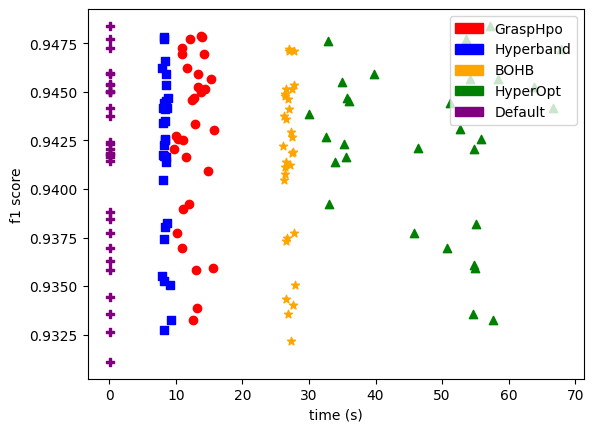

In [48]:
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300 #uncomment this to make plots with higher resolution

plot_multi_run(rand_early_runs,"Ereno")

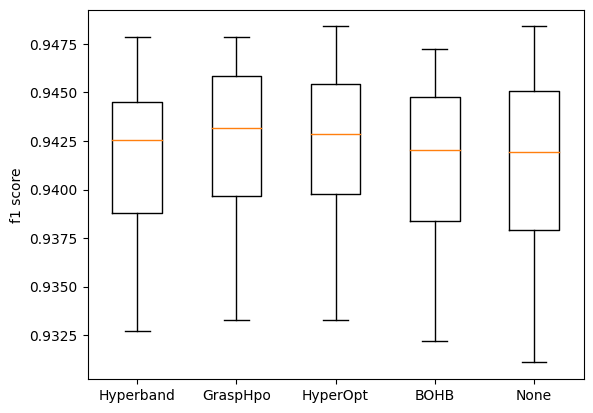

In [49]:
plot_multi_boxplot_f1(rand_early_runs,"Ereno")

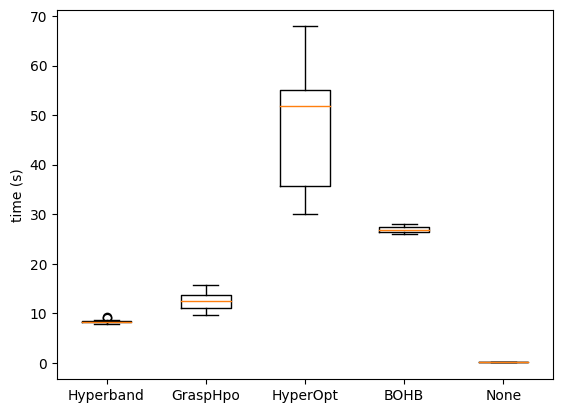

In [51]:
plot_multi_boxplot_time(rand_early_runs,"Ereno")